In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
from itertools import product
import numpy as np
import re

In [9]:
from min_bisection import solution_schema

In [10]:
root_fldr = 'runs\\v0.4'

In [12]:
def subdir_paths(folder):
    return [os.path.join(folder, f) for f in next(os.walk(folder))[1] if f != 'profiles']

meta_dfs = []
run_dfs = []
fldrs = subdir_paths(root_fldr)
for fldr in fldrs:
    print(fldr)
    sub_fldrs = subdir_paths(fldr)
    for sub_fldr in sub_fldrs:
        data_fldrs = subdir_paths(sub_fldr)
        for data_fldr in data_fldrs:
            meta_dfs.append(pd.read_csv(os.path.join(data_fldr, 'summary_stats.csv')))
            run_dfs.append(pd.read_csv(os.path.join(data_fldr, 'run_stats.csv')))
            
for key, df_list in {'summary': meta_dfs, 'run': run_dfs}.items():
    df = pd.concat(df_list)
    df['threshold_proportion'] = df['threshold_proportion'].fillna(0)
    df.to_csv(os.path.join(root_fldr, f'{key}_stats.csv'), index=False)
    
meta = pd.read_csv(os.path.join(root_fldr, 'summary_stats.csv'))
run = pd.read_csv(os.path.join(root_fldr, 'run_stats.csv'))

runs\v0.4\large_no_random_pp
runs\v0.4\large_pp
runs\v0.4\no_random_pp
runs\v0.4\random_pp
runs\v0.4\small_no_random_pp
runs\v0.4\small_random_pp


In [16]:
meta.head()

,solve_id,solve_type,method,warm_start,min_search_proportion,threshold_proportion,n,p,q,cut_type,cut_value,max_variables,max_constraints,total_cpu_time,gurobi_cpu_time,non_gurobi_cpu_time,objective_value
0,0,iterative,auto,warm,1.0,0.0,110,0.5,0.1,fixed,1000,5995,11101,135.781741,99.627789,36.153952,310.0
1,1,iterative,auto,warm,1.0,0.0,110,0.5,0.1,fixed,10000,5995,21476,40.240916,26.093474,14.147442,313.0
2,10,iterative,auto,warm,1.0,0.0,110,0.5,0.2,fixed,1000,5995,13529,1124.302644,1081.467191,42.835453,586.0
3,11,iterative,auto,warm,1.0,0.0,110,0.5,0.2,fixed,10000,5995,40101,1300.297241,1282.099023,18.198218,588.0
4,12,iterative,auto,warm,1.0,0.0,110,0.8,0.1,fixed,1000,5995,5101,18.167226,0.250816,17.916410,304.0


In [17]:
run.head()

,solve_id,solve_type,method,warm_start,min_search_proportion,threshold_proportion,sub_solve_id,n,p,q,cut_type,cut_value,cuts_sought,cuts_added,search_proportion_used,current_threshold,variables,constraints,cpu_time
0,0,iterative,auto,warm,1.0,0.0,0,110,0.5,0.1,fixed,1000,100,100,1.0,NaN,5995,101,0.011814
1,0,iterative,auto,warm,1.0,0.0,1,110,0.5,0.1,fixed,1000,1000,1000,1.0,NaN,5995,1101,0.050184
2,0,iterative,auto,warm,1.0,0.0,2,110,0.5,0.1,fixed,1000,1000,1000,1.0,NaN,5995,2101,0.086455
3,0,iterative,auto,warm,1.0,0.0,3,110,0.5,0.1,fixed,1000,1000,1000,1.0,NaN,5995,3101,0.138049
4,0,iterative,auto,warm,1.0,0.0,4,110,0.5,0.1,fixed,1000,1000,1000,1.0,NaN,5995,4101,0.226674


In [18]:
def cpu_time_graph(time_measure, ignored_patterns, line_style):
    col_selection = time_measure if time_measure != 'proportion_cpu_time_gurobi' else ['total_cpu_time', 'gurobi_cpu_time']
    # average the runs
    gd = meta.groupby(['p', 'q', 'solve_type', 'cut_value', 'min_search_proportion', 'threshold_proportion', 'n'])[col_selection].mean().reset_index()
    gd['idx'] = gd['solve_type'] + '_' + gd['cut_value'].astype(str) + '_' + gd['min_search_proportion'].astype(str) + '_' + gd['threshold_proportion'].astype(str)

    # filter graph data by data set
    filters = {idx: gd['idx'] == idx for idx in gd['idx'].unique()}

    # graph for each p, q combination 
    for (p, q) in product(gd['p'].unique(), gd['q'].unique()):
        for name, fltr in filters.items():
            # groups to filter out
            if any([ip in name for ip in ignored_patterns]):
                continue
            subset = gd.loc[(gd['p'] == p) & (gd['q'] == q) & fltr].sort_values('n')
            # assign line style to group
            match = re.search('iterative_(.*)_.*_.*', name).group(1) if re.search('iterative_(.*)_.*_.*', name) else 'no_match'
            style = line_style.get(match, '-')
            if isinstance(col_selection, list):
                plt.plot(subset['n'], subset[col_selection[1]]/subset[col_selection[0]], linestyle=style, label=name)
                plt.ylabel('proportion_of_cpu_time')
            else:
                plt.plot(subset['n'], subset[col_selection], linestyle=style, label=name)
                plt.ylabel('cpu_time')

        plt.title(f'{time_measure} comparison for p={p}, q={q}')
        plt.xlabel('n')
        plt.legend()
        plt.show()

## Settings

In [52]:
ignored_patterns = ['10_',
                    '100_',
#                     '1000_',
                    '10000',
                    '100000_',
                    '1000000_']

line_style = {
    '10': ':',
    '100': '-.',
    '1000': '--',
    '10000': ':',
    '100000': '-.',
    '1000000': '--'
}

## Total CPU Time

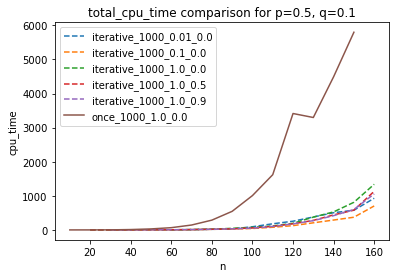

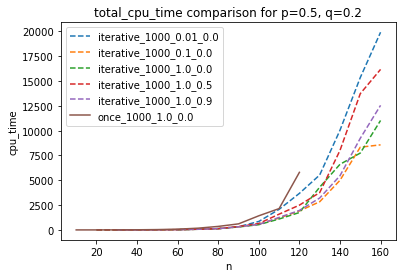

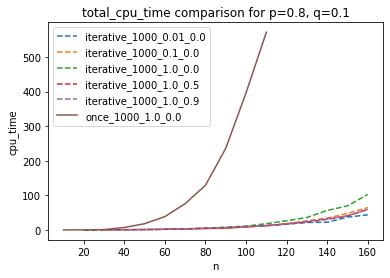

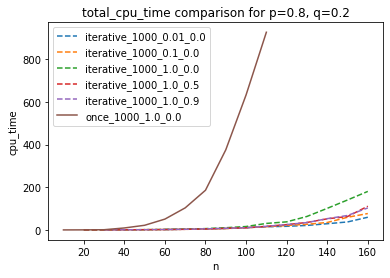

In [53]:
time_measure = 'total_cpu_time'
cpu_time_graph(time_measure, ignored_patterns, line_style)

## Gurobi CPU Time

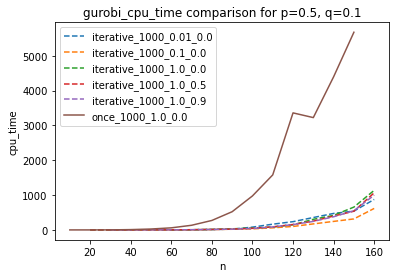

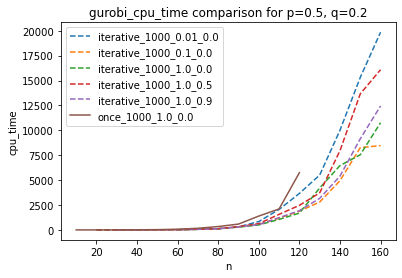

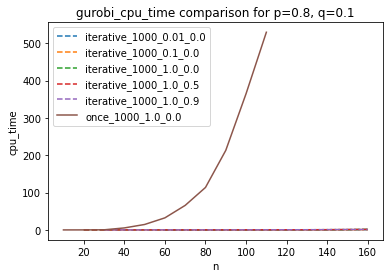

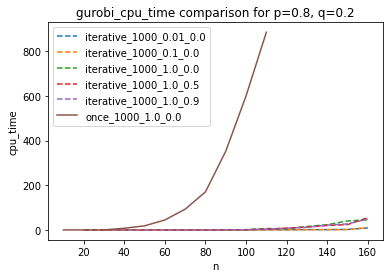

In [54]:
time_measure = 'gurobi_cpu_time'
cpu_time_graph(time_measure, ignored_patterns, line_style)

## Proportion CPU Time Gurobi

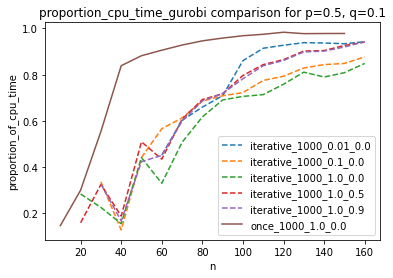

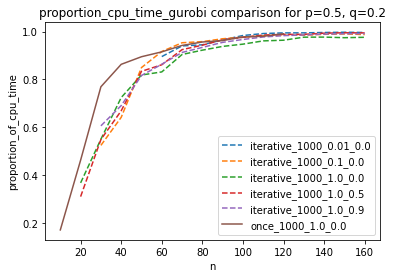

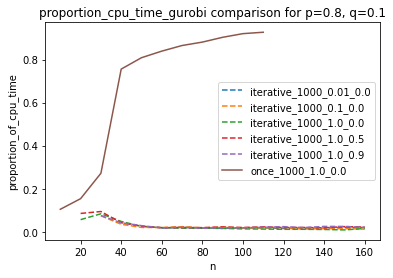

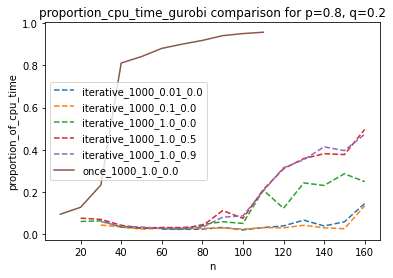

In [55]:
time_measure = 'proportion_cpu_time_gurobi'
cpu_time_graph(time_measure, ignored_patterns, line_style)

## Number of LP's per Solve

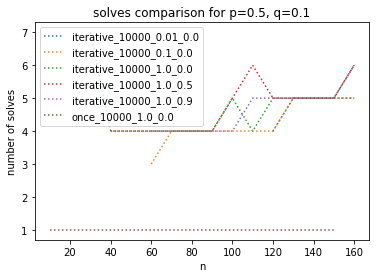

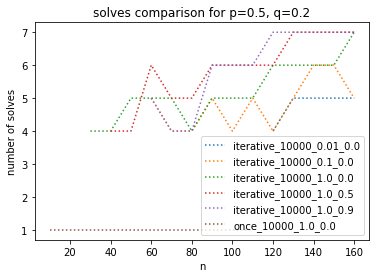

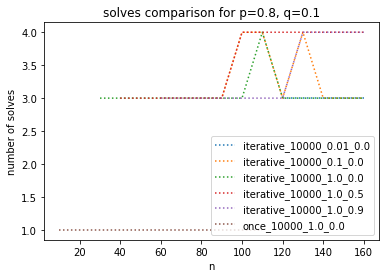

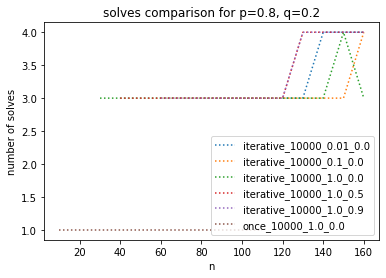

In [44]:
# count number of runs
gd = run.groupby(['p', 'q', 'solve_type', 'cut_value', 'min_search_proportion', 'threshold_proportion', 'n'])['sub_solve_id'].max().reset_index()

# create id
gd['idx'] = gd['solve_type'] + '_' + gd['cut_value'].astype(str) + '_' + gd['min_search_proportion'].astype(str) + '_' + gd['threshold_proportion'].astype(str)

# rename and adjust for 0 indexing
gd.rename(columns={'sub_solve_id': 'solves'}, inplace=True)
gd['solves'] += 1

# filter graph data by data set
filters = {idx: gd['idx'] == idx for idx in gd['idx'].unique()}

# graph for each p, q combination 
for (p, q) in product(gd['p'].unique(), gd['q'].unique()):
    for name, fltr in filters.items():
        if any([ip in name for ip in ignored_patterns]):
            continue
        subset = gd.loc[(gd['p'] == p) & (gd['q'] == q) & fltr].sort_values('n')
        style = line_style.get(re.search('\w+_(.*)_.*_.*', name).group(1), '-')
        plt.plot(subset['n'], subset['solves'], linestyle=style, label=name)

    plt.title(f'solves comparison for p={p}, q={q}')
    plt.ylabel('number of solves')
    plt.xlabel('n')
    plt.legend()
    plt.show()